<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_Ciencia_de_Dados/blob/main/IMT_ARIMA_solucao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **Séries Temporais: AR, MA, ARMA e ARIMA**

## Roteiro para um modelo ARIMA

1. Visualize e explore a série temporal
2. Prepare os dados  
3. Verifique a estacionariedade e obtenha a série estacionária  
4. Identifique o modelo: determine a ordem de diferenciação dos termos (d), AR (p) e MA (q) usando gráficos ACF e PACF
5. Ajuste e seleção do modelo, `ARIMA().fit()`
6. Analise os resíduos
7. Gere e analise as previsões, `model.forecast()`
8. `Autoarima`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
import matplotlib.dates as mdates
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

import scipy.stats as stats

## 1. Visualize e explore a série temporal

In [ ]:
df = pd.read_csv('https://github.com/Rogerio-mack/Temporal/raw/main/Data/Delta_LOD.csv',sep=';',usecols=['year', 'month', 'day', 'lod(ms)', 'sig(ms)'])
df.head()

,year,month,day,lod(ms),sig(ms)
0,1962,1,1,1.723,1.4
1,1962,1,2,1.669,1.4
2,1962,1,3,1.582,1.4
3,1962,1,4,1.496,1.4
4,1962,1,5,1.416,1.4


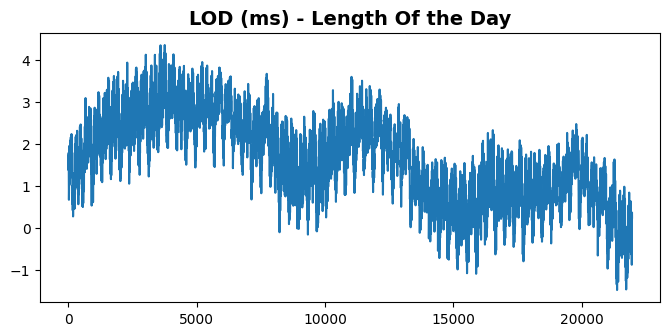

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(df['lod(ms)'])
plt.title('LOD (ms) - Length Of the Day',weight='bold',fontsize=14)
plt.show()

## 2. Prepare os dados

Nós queremos trabalhar com a variação do LOD anual, isto é, a série anual dos valores de LOD. Para isso,

**1. Crie um índice no formato datetime para o dataframe dos dados.**

> *O uso de índices tipo datetime permite que o pandas identifique que é uma série temporal e opere várias funções úteis.*

**2. Faça uma reamostra (`resample`) dos dados para gerar os valores anuais `df_year` (opcionalmente gere os dados mensais também).** Plot os dados diários da série original e os dados anuais que você produziu (opcionalmente inclua também a série mensal).

> *O resample pela média é o mais útil aqui.*

O gráfico, ao final, deve ter o seguinte aspecto:






In [ ]:
df.index = pd.to_datetime(df[["year", "month", "day"]])
df.head()

,year,month,day,lod(ms),sig(ms)
1962-01-01,1962,1,1,1.723,1.4
1962-01-02,1962,1,2,1.669,1.4
1962-01-03,1962,1,3,1.582,1.4
1962-01-04,1962,1,4,1.496,1.4
1962-01-05,1962,1,5,1.416,1.4


In [ ]:
df[['lod(ms)']].resample('Y').mean().values.T

array([[ 1.30519452,  1.52584384,  1.94535792,  2.1957863 ,  2.43217534,
         2.36548767,  2.48578962,  2.67165753,  2.70929863,  2.90535068,
         3.12517213,  3.04433699,  2.71601644,  2.69149315,  2.90073497,
         2.77876712,  2.87928219,  2.61327397,  2.2989153 ,  2.15356986,
         2.16431781,  2.27925973,  1.51450328,  1.44791616,  1.23711123,
         1.36219315,  1.31272923,  1.52034247,  1.9450389 ,  2.03824027,
         2.21929617,  2.36351589,  2.19406575,  2.31151562,  1.8206276 ,
         1.83840932,  1.37265644,  0.99177671,  0.71632459,  0.56967589,
         0.47512658,  0.27375973,  0.30999208,  0.43113123,  0.82344521,
         0.85146219,  0.87200601,  0.8035989 ,  0.69703041,  0.76060411,
         0.8299429 ,  1.02366411,  0.99387288,  1.25464548,  1.34141885,
         1.0271011 ,  0.69077288,  0.38642411, -0.00428279, -0.17913205,
        -0.12921509]])

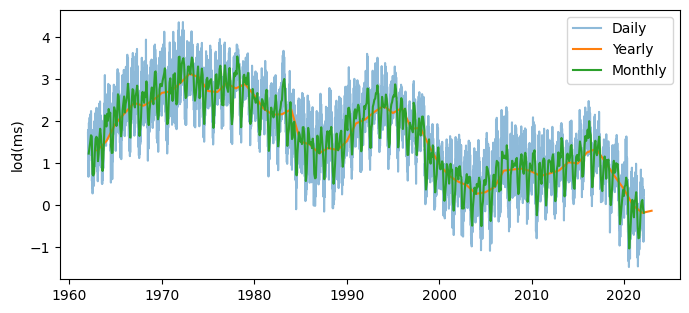

In [ ]:
plt.figure(figsize=(8,3.5))

df_year = df[['lod(ms)']].resample('Y').mean()
df_month = df[['lod(ms)']].resample('M').mean()

sns.lineplot(x=df.index, y=df['lod(ms)'],alpha=0.5,label='Daily')
sns.lineplot(x=df_year.index, y=df_year['lod(ms)'],label='Yearly')
sns.lineplot(x=df_month.index, y=df_month['lod(ms)'],label='Monthly')

plt.legend()
plt.show()

**Atenção**: Daqui em diante **vamos empregar apenas a série anual obtida**.

### Q1.
Qual a data e o último valor da série anual?

In [ ]:
df_year.iloc[-1]

lod(ms)   -0.129215
Name: 2022-12-31 00:00:00, dtype: float64

## 3. Verifique a estacionariedade e obtenha a série estacionária

Muitas vezes podemos verificar se uma série é ou não estacionária apenas visualizando a série.

> *Lembre-se, uma série estacionária é aquela que mantêm suas estatísticas ao longo do tempo.*

### Q2.

A Série é claramente não estacionária? Por quê?

Há também vários testes de hipóteses para verificação da estacionariedade. O teste de Dickey-Fuller é um dos mais comumente empregados.

**Faça aqui o teste de Dickey-Fuller sobre a série anual e verifique se ela é ou não estacionária.**

> *Lembre-se, p-value > 0.05 neste teste rejeita a hipótese de que a série é estacionária.*

### Q3.

Qual o p-value obtido do teste de Dickey-Fuller com a série anual? A série obtida é estacionária pelo teste?

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_year['lod(ms)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.341426
p-value: 0.610014


### Obtendo a série estacionária

> *A série estacionária vai permitir obtermos os melhores valores de p,d,q para nosso modelo.*

Diferentes transformações podem ser empregadas para tornar uma série estacionária, mas a mais comum é a transformação em uma série de diferenças (`diff`, diferenciação).

**Obtenha a série de diferenças de ordem 1 e verifique se a série obtida é estacionária aplicação do teste de Dickey-Fuller.**

In [ ]:
df_year_diff1 = df_year[['lod(ms)']].diff()
df_year_diff1 = df_year_diff1.dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_year_diff1['lod(ms)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.693371
p-value: 0.004207


### Q4.

Qual o p-value obtido do teste de Dickey-Fuller com a série de diferenças? A série obtida é estacionária pelo teste?

## 4. Identifique o modelo: determine a ordem de diferenciação dos termos (d), AR (p) e MA (q) usando gráficos ACF e PACF

Os parâmetros do modelo `ARIMA(p,d,q)` são definidos da seguinte forma:

- **p**: O número de termos autogressivos ou de atraso incluídos no modelo.
- **d**: A ordem em que a série é diferenciada, ou de *grau de diferenciação*.
- **q**: A ordem da janela da média móvel, ou *ordem da média móvel*.

### Ordem de diferenciação dos termos, d=1

Podemos empregar uma ordem 1 de diferenciação, uma vez que obtivémos uma série estacionária com a série de diferenças de ordem 1.

### AR (p) e MA (q)

A ordem dos termos autoregressivos e a ordem do erro das médias móveis pode ser obtido respectivamente pelos gráficos PACF e ACF.

**Faça os gráficos ACF e PACF.**

### Q5.

Qual a ordem significativa dos termos autoregressivos, p?

### Q6.

Qual a ordem significativa dos termos dos erros da média móvel, q?

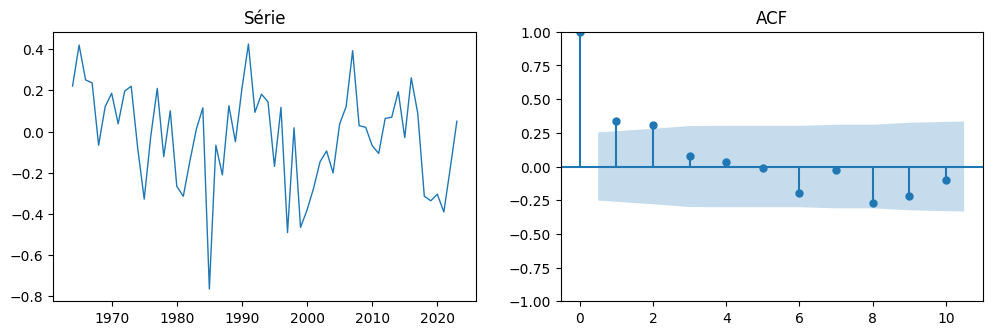

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,3.5))
ax1.plot(df_year_diff1['lod(ms)'],linestyle='solid',alpha=1,lw=1)
ax1.title.set_text('Série')
y=plot_acf(df_year_diff1['lod(ms)'], lags=10,ax=ax2, title="ACF")

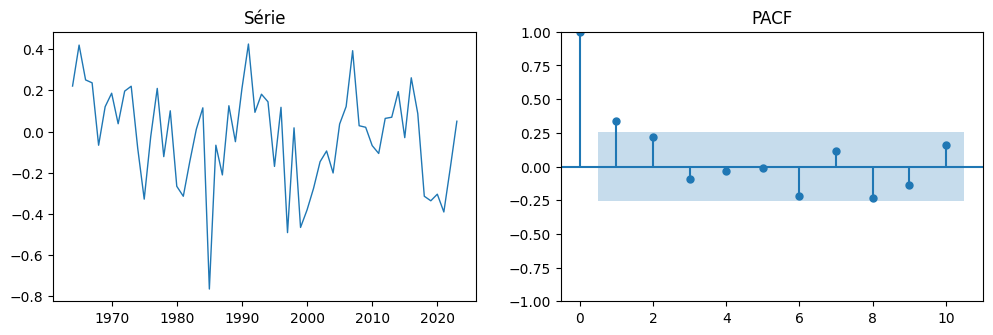

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,3.5))
ax1.plot(df_year_diff1['lod(ms)'],linestyle='solid',alpha=1,lw=1)
ax1.title.set_text('Série')
y=plot_pacf(df_year_diff1['lod(ms)'], lags=10,ax=ax2, title="PACF")

> *De acordo com os parâmetros passados na função `ARIMA(p,d,q)` podem ser criados modelos mais simples como AR, MA e ARMA.*

\begin{array}{c c c}
\hdashline
\text{Model}&\text{Statsmodels}&\text{Series type}\\ \hdashline
AR & ARIMA(dados, order=(p, 0, 0)) & \text{stacionary} \\
MA & ARIMA(dados, order=(0, 0, q)) & \text{stacionary} \\
ARMA & ARIMA(dados, order=(p, 0, q)) & \text{stacionary} \\
ARIMA & ARIMA(dados, order=(p, d, q)) & \text{non stacionary} \\   \hdashline
\end{array}

## 5. Ajuste e seleção do modelo, `ARIMA().fit()`

**Ajuste o modelo ARIMA(p,d,q) empregando os valores encontrados.** Em seguida, plot os valores da série anual e dos valores estimados. O gráfico deve ser semelhante ao que você encontra logo em seguida.


### Q7.

Qual o AIC (critério de informação de Akaike) e MSE encontrados?

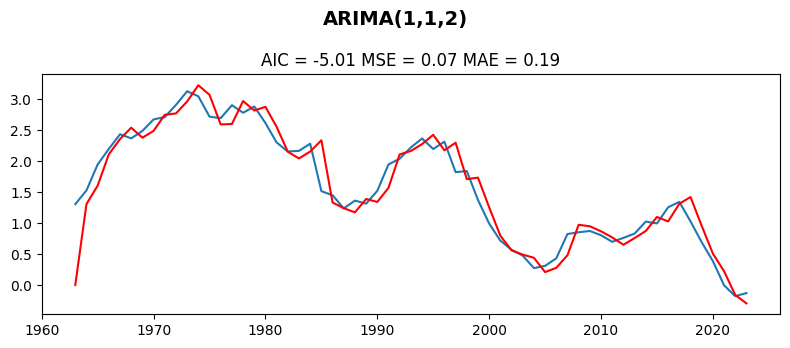

In [ ]:
plt.figure(figsize=(8,3.5))

p = 1; d = 1; q = 2
model = ARIMA(df_year['lod(ms)'], order=(p, d, q))
results = model.fit(method_kwargs={'maxiter':700})

plt.plot(df_year['lod(ms)'],label='real')
plt.plot(results.fittedvalues, color='red',label='model')

plt.title(f'AIC = {results.aic:.2f} MSE = {results.mse:.2f} MAE = {results.mae:.2f}')
plt.suptitle(f'ARIMA({p},{d},{q})',weight='bold',fontsize=14)

plt.tight_layout()
plt.show()

**Faça um report do modelo**.



### Q9.

Quais os coeficientes estimados para a parcela MA?

In [ ]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                lod(ms)   No. Observations:                   61
Model:                 ARIMA(1, 1, 2)   Log Likelihood                   6.505
Date:                Tue, 31 Oct 2023   AIC                             -5.010
Time:                        11:12:05   BIC                              3.367
Sample:                    12-31-1962   HQIC                            -1.733
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4166      0.467      0.892      0.372      -0.499       1.332
ma.L1         -0.1345      0.467     -0.288      0.774      -1.050       0.781
ma.L2          0.2015      0.194      1.040      0.2

Experimente outros valores de p,d,q e verifique os resultados.   

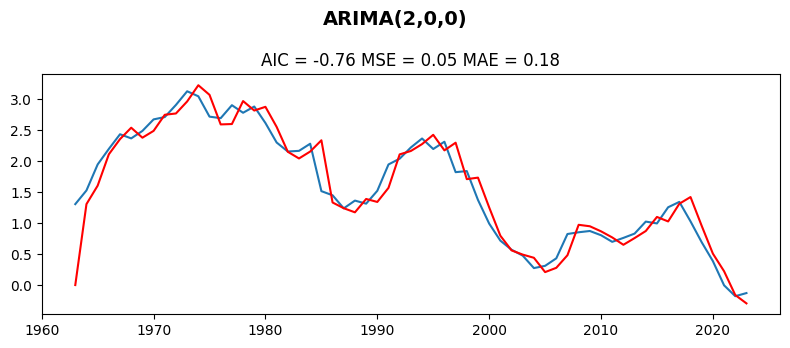

In [ ]:
plt.figure(figsize=(8,3.5))

p = 2; d = 0; q = 0
model_2 = ARIMA(df_year['lod(ms)'], order=(p, d, q))
results_2 = model_2.fit(method_kwargs={'maxiter':700})

plt.plot(df_year['lod(ms)'],label='real')
plt.plot(results.fittedvalues, color='red',label='model')

plt.title(f'AIC = {results_2.aic:.2f} MSE = {results_2.mse:.2f} MAE = {results_2.mae:.2f}')
plt.suptitle(f'ARIMA({p},{d},{q})',weight='bold',fontsize=14)

plt.tight_layout()
plt.show()


## 6. Analise os resíduos


> *O que se espera é que os resíduos tenham uma distribuição normal e não sejam autocorrelacionados.*

### Q10.

As componentes de erro são não correlacionadas como o esperado?

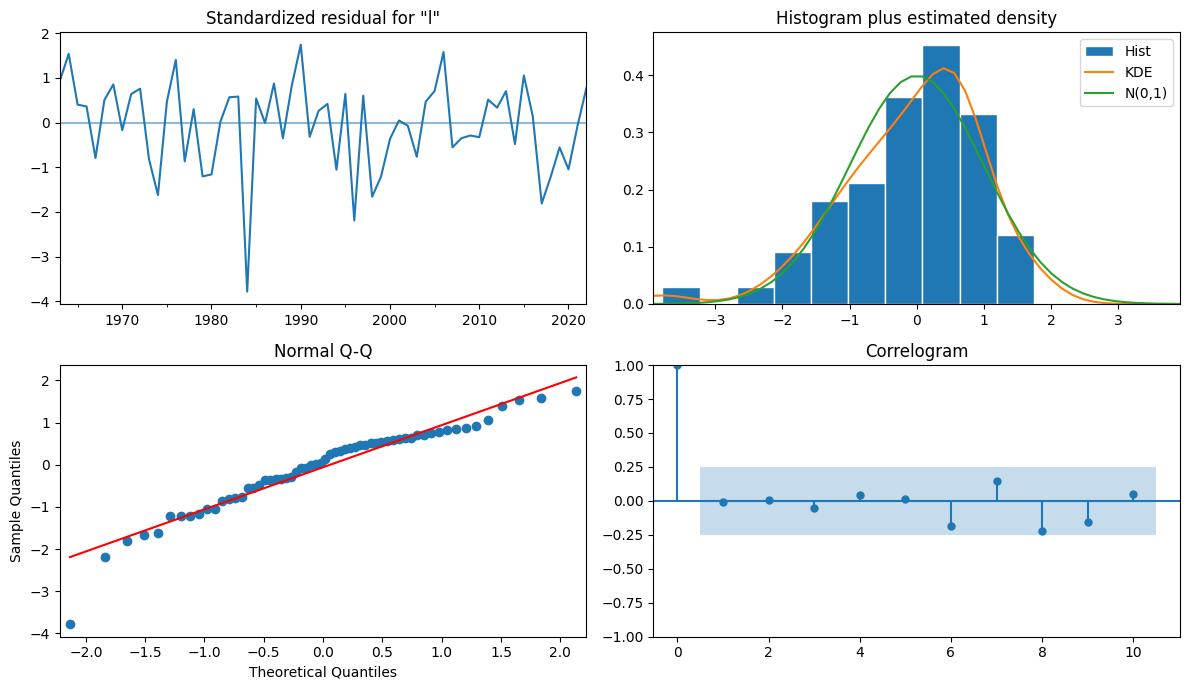

In [ ]:
fig = plt.figure(figsize=(12,7))

results.plot_diagnostics(fig=fig)

plt.tight_layout()
plt.show()

## 7. Gere e analise as previsões, `model.forecast()`

**Gere uma predição para os próximos 5 anos. Plot os valores obtidos.**

### Q11.

Qual o valor obtido para 2027?

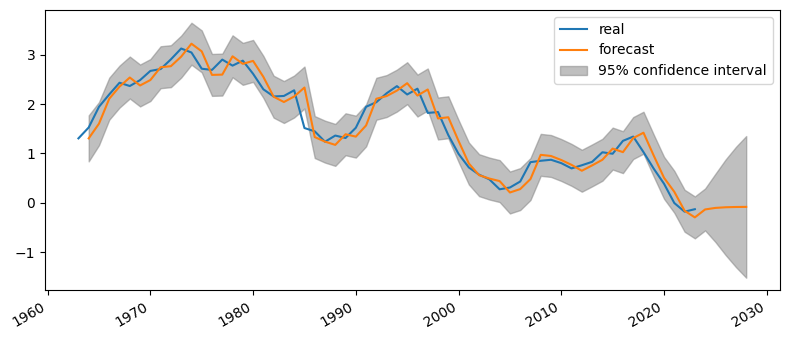

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(df_year['lod(ms)'],label='real')
plot_predict(results, start='1963-12-31', end='2027-12-31', ax=ax)
# plot_predict(results, start=1, end=len(df_year['lod(ms)']) + 5,ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
results.forecast(10)

2023-12-31   -0.134430
2024-12-31   -0.103157
2025-12-31   -0.090129
2026-12-31   -0.084701
2027-12-31   -0.082440
2028-12-31   -0.081498
2029-12-31   -0.081106
2030-12-31   -0.080942
2031-12-31   -0.080874
2032-12-31   -0.080846
Freq: A-DEC, Name: predicted_mean, dtype: float64

# SARIMA

Podemos observar uma certa sazonalidade na série o que poderia sugerir o emprego de um modelo SARIMA, que modela a componente de sazonalidade do mesmo modo que o modelo ARIMA. Há, entretanto,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


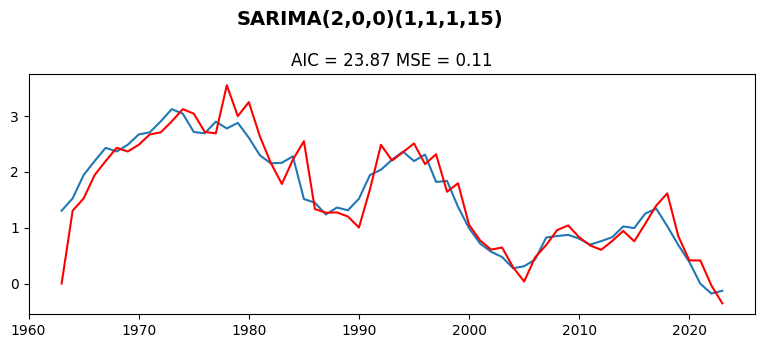

In [ ]:
plt.figure(figsize=(8,3.5))

model = SARIMAX(df_year['lod(ms)'], order=(1, 1, 2), seasonal_order=(1,1,1,15))
results = model.fit(maxiter=1500)

plt.plot(df_year['lod(ms)'])
plt.plot(results.fittedvalues, color='red')

plt.title(f'AIC = {results.aic:.2f} MSE = {results.mse:.2f}')
plt.suptitle(f'SARIMA({p},{d},{q})(1,1,1,15)',weight='bold',fontsize=14)

plt.tight_layout()
plt.show()

## 8. Autoarima

O `pmdarima` é um pacote que se propõe a produzir uma seleção automática de modelos regressivos e de médias móveis.

> *Cuidado: o pacote `pmdarima` pode trazer inconsistência no pacote `statsmodels`. Prefira trabalhar com os pacotes em separado.*

Abaixo você encontra algumas das principais funções que empregamos aqui com o `statsmodel` com o `pmdarima`.

### Q12.

O pmdarima e statsmodel fornecem os mesmos resultados para os mesmos vlaores p,d,q?

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

# ADF Test
print(f'ADF, d = { ndiffs(df_year["lod(ms)"], test="adf")} ')

# KPSS Test
print(f'KPSS, d = { ndiffs(df_year["lod(ms)"], test="kpss")} ')

# PP Test
print(f'PP, d = { ndiffs(df_year["lod(ms)"], test="pp")} ')

ADF, d = 2 
KPSS, d = 1 
PP, d = 1 


In [ ]:
auto_arima = pm.auto_arima(df_year["lod(ms)"], stepwise=False, seasonal=False,trace=True)
auto_arima

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.485, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1.168, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4.736, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2.816, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4.287, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-2.343, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3.720, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3.577, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3.144, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1.200, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-2.306, Time=0.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5.028, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3.292, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1.432, Time=1.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=0.522, Time=0.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
print( auto_arima.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(3, 1, 1)   Log Likelihood                   8.591
Date:                Tue, 31 Oct 2023   AIC                             -5.181
Time:                        11:12:21   BIC                              7.385
Sample:                    12-31-1962   HQIC                            -0.266
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0053      0.004     -1.349      0.177      -0.013       0.002
ar.L1          1.1762      0.169      6.948      0.000       0.844       1.508
ar.L2          0.0305      0.225      0.136      0.8

In [ ]:
y_pred, ci = auto_arima.predict_in_sample(X=None, return_conf_int=True)
y_pred

1962-12-31   -0.035669
1963-12-31    1.269525
1964-12-31    1.590491
1965-12-31    2.106176
1966-12-31    2.344249
                ...   
2018-12-31    0.888315
2019-12-31    0.440989
2020-12-31    0.177444
2021-12-31   -0.182716
2022-12-31   -0.297383
Freq: A-DEC, Length: 61, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mean_squared_error(df_year["lod(ms)"], y_pred)

0.07297567116303322

In [ ]:
forecast_test_auto, ci = auto_arima.predict(n_periods=5, return_conf_int=True)
forecast_test_auto

2023-12-31   -0.105466
2024-12-31   -0.019190
2025-12-31    0.059985
2026-12-31    0.142016
2027-12-31    0.204976
Freq: A-DEC, dtype: float64

In [ ]:
results.forecast(5)

2023-12-31   -0.107730
2024-12-31   -0.155726
2025-12-31   -0.163530
2026-12-31   -0.321273
2027-12-31   -0.329813
Freq: A-DEC, Name: predicted_mean, dtype: float64

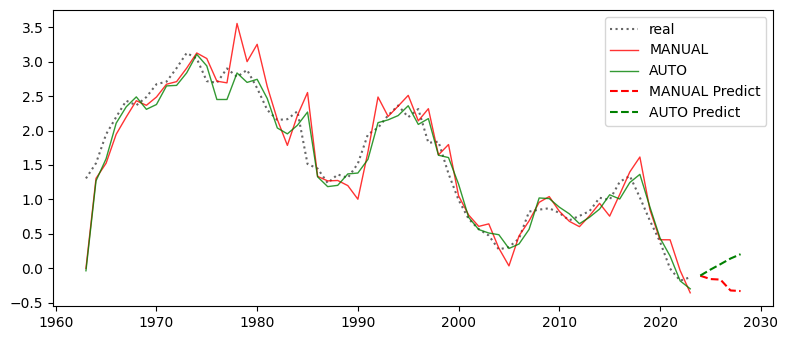

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(df_year['lod(ms)'],'k:',label='real',alpha=0.6)
ax.plot(results.fittedvalues, 'r',label='MANUAL',lw=1,alpha=0.8)
ax.plot(y_pred, 'g',label='AUTO',lw=1,alpha=0.8)

ax.plot(results.forecast(5).index, results.forecast(5),'r--', label='MANUAL Predict')
ax.plot(forecast_test_auto.index, forecast_test_auto,'g--',label='AUTO Predict')

plt.legend()

plt.tight_layout()
plt.show()